In [131]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from scipy.optimize import curve_fit
from functools import partial,wraps,reduce
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(0)

In [145]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

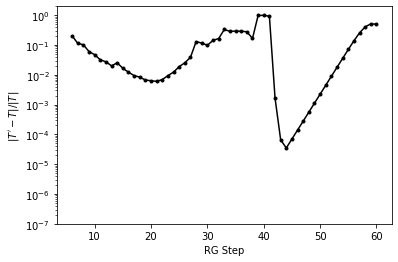

  0%|          | 0/61 [00:00<?, ?it/s]

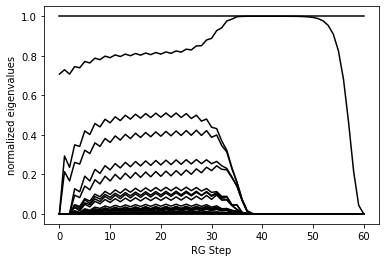

  0%|          | 0/61 [00:00<?, ?it/s]

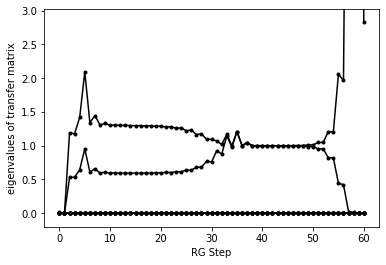

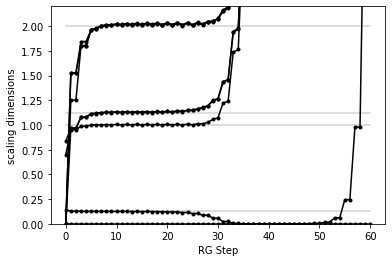

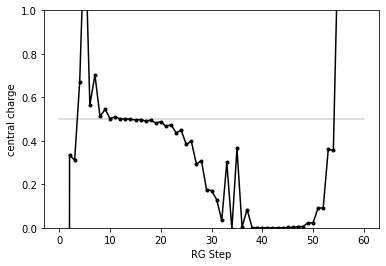

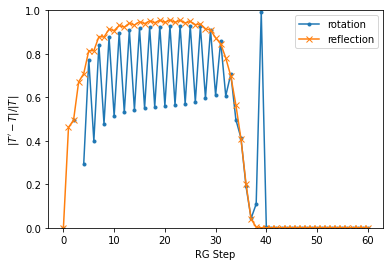

In [146]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':(16,12),
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    #'gilt_record_S':True,
    'mcf_enabled':True,
    #'mcf_enabled_unitary':True,
    'mcf_eps':1e-6,
    'mcf_max_iter':50,
    #'hotrg_sanity_check':True,
    #'hotrg_sanity_check_tol':1e-7,
}

#params=AKLT2D.get_default_params()
#params['a2']=2.86522
#params['a2']=2.86521
#model=AKLT2D(params)
#T0=model.get_T0()
#T0_op1,T0_op2,checkerboard=model.get_ST0(2),model.get_ST0(2),True
#correlator_name='SZSZ'


params=Ising2D.get_default_params()
#params['beta']-=.005
model=Ising2D(params)
T0=model.get_T0()
P0=model.get_PEPS()
P0[:,:,:,:,1]*=.1
P0=P0[:,:,:,:,:options['max_dim'][1]]
#P0=P0[:,:,:,:,:1]
#P0[:,:,:,:,1]*=.1
#P0=P0[:,:,:,:,:1]
T0_op1,T0_op2,checkerboard=model.get_SZT0(),model.get_SZT0(),False



reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

#layers=HOTRG_layers(P0,dimR=dimR,
#                        max_dim=options['max_dim'],nLayers=options['nLayers'],
#                        options=options)

layers=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'][0],nLayers=options['nLayers'],
                        options=options)

for layer in layers:
    #layer.delete_PEPS_()
    #delete_gilt_truncation_(layer)
    pass

Ts,T_ops,logTotals=forward_observable_tensor(T0,T0_op1,
                        layers=layers,checkerboard=checkerboard,
                        return_layers=True,
                        cached_Ts=None)

#print(trace_two_tensors(T_ops[-1]))
    
show_diff(Ts,stride=2)
show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)
show_asymmetry(Ts)

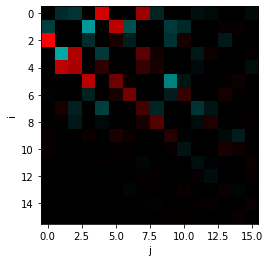

In [113]:
from utils import show_matrix

g0,g1=layers[20].gg
g0,g1,g2,g3=g0
show_matrix((g2).cpu());plt.show()

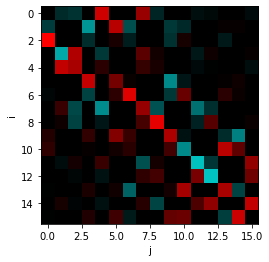

In [117]:
from safe_svd import svd
u,s,vh=svd(g2)
show_matrix((u@vh).cpu())

In [147]:
data=pd.DataFrame()

correlator_name=r'$\langle\phi(0)\phi(r,\theta)\rangle$'
coordss=[]
for i in range(30):
    lattice_size=get_lattice_size(len(layers),spacial_dim=len(T0.shape)//2)
    th=np.random.uniform(0,np.pi/2)
    r=np.exp(np.random.uniform(np.log(1),np.log(min(lattice_size))))
    x,y=int(np.abs(r*np.cos(th))),int(np.abs(r*np.sin(th)))
    coordss.append((x,y))
    #x,y=int(lattice_size[0]-r),0
    #coordss.append((x,y))
    #x,y=int(r),0
    #coordss.append((x,y))

for coords in tqdm(coordss):
    if not(all(isinstance(c,int) and 0<=c and c<s for c,s in zip(coords,lattice_size))):continue
    if all(c==0 for c in coords):continue
        

    T,T_op12,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2],[(0,)*len(coords),coords],\
                               layers=layers,checkerboard=checkerboard,\
                               cached_Ts=Ts)
    correlation=_toN(trace_tensor(T_op12)/trace_tensor(T))
    newRow={**params,
        **options,
        'x':coords[0],'y':coords[1],
        'correlation':correlation,}
    
    data=data.append(newRow,ignore_index=True)
#data

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

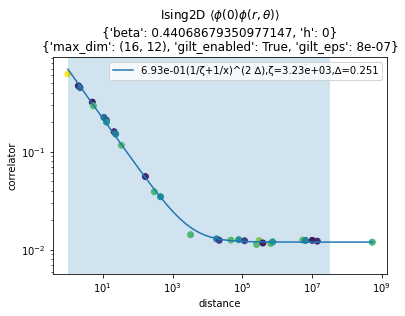

In [148]:
assert(all(data['correlation']>=-1e-7))

data['dist']=get_dist_torus_2D(data['x'].to_numpy(),data['y'].to_numpy(),lattice_size)
data['correlation_abs']=np.abs(data['correlation'])


data['theta']=np.arctan2(data['x'],data['y'])


def ansatz1(x,A,zeta,delta): #high temperature
    return A*np.exp(-x/zeta)*x**(-2*delta)
ansatz1_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ),ζ={1:.2e},Δ={2:.3f}'
ansatz1_p0=(1,100,0.1)

def ansatz3(x,A,zeta,delta,n): #low temperature
    return A*(1+(zeta/x)**n)**(2*delta/n)
ansatz3_eq='{0:.2e}(1+(ζ/x)^n)^(2 ∆/n),ζ={1:.2e},∆={2:.3f},n={3:.1f}'
ansatz3_p0=(1,100,0.1,2)

def ansatz4(x,A,zeta,delta):  #low temperature
    return A*(1/zeta+1/x)**(2*delta)
ansatz4_eq='{0:.2e}(1/ζ+1/x)^(2 ∆),ζ={1:.2e},∆={2:.3f}'
ansatz4_p0=(1,100,0.1)

def ansatz5(x,A,zeta,delta,m0):  #low temperature nikko
    return A*np.exp(-x/zeta)*x**(-2*delta)+m0**2
ansatz5_eq='{0:.2e}e^(-x/ζ)/x^(2 Δ)+m0^2,ζ={1:.2e},Δ={2:.3f},m0={3:.3f}'
ansatz5_p0=(1,1000,0.1,0.1)


    

def loglog(foo):
    @wraps(foo)
    def goo(logX,*p):
        return np.log(foo(np.exp(logX),*p))
    return goo


if data['correlation_abs'].min()<1e-5:
    ansatz,ansatz_eq,ansatz_p0=ansatz1,ansatz1_eq,ansatz1_p0
    threshold=min(data[data['correlation_abs']>1e-2]['dist'].max(),2**(options['nLayers']//2-5))
else:
    #ansatz,ansatz_eq,ansatz_p0=ansatz3,ansatz3_eq,ansatz3_p0
    ansatz,ansatz_eq,ansatz_p0=ansatz4,ansatz4_eq,ansatz4_p0
    #ansatz,ansatz_eq,ansatz_p0=ansatz5,ansatz5_eq,ansatz5_p0
    threshold=2**(options['nLayers']//2-5)

data1=data[(data['dist']<threshold)].sort_values('dist')

try:
    p,cov=curve_fit(loglog(ansatz),np.log(data1['dist']),np.log(data1['correlation_abs']),p0=ansatz_p0,maxfev=10000)
except Exception as err:
    print(err)
    p,cov=None,None

data1=data.sort_values('dist')
plt.scatter(data1['dist'],data1['correlation_abs'],c=data1['theta'])
if p is not None:
    ls=np.geomspace(data1['dist'].min(),data1['dist'].max())
    plt.plot(ls,ansatz(ls,*p),'-',label=ansatz_eq.format(*p))
    plt.legend()
#plt.axvline(threshold,color='black')
plt.axvspan(1,threshold, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlator')
plt.ylim([max(1e-5,data['correlation_abs'].min()*.5),data['correlation'].max()*1.5])
#plt.title(f'{type(model).__name__} HOTRG {correlator_name}\n{params}\n{options}')
plt.title(f'{type(model).__name__} {correlator_name}\n{params}\n{ {k:options[k] for k in ["max_dim","gilt_enabled","gilt_eps"]} }')
plt.show()